<a href="https://colab.research.google.com/github/georgeY123-AI/Project-Advanced-Text-to-Image-Generation/blob/main/DEPI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install diffusers transformers accelerate torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.6 MB/s eta 0:00:00


In [ ]:
!pip install -q scipy safetensors

In [ ]:
!pip install -q nltk contractions pycocotools requests tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (344 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import os
import requests

# Create directories
os.makedirs("coco_mini/annotations", exist_ok=True)
os.makedirs("coco_mini/images", exist_ok=True)

# Download captions (4.6MB)
annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
!wget {annotations_url} -O coco_annotations.zip
!unzip -j coco_annotations.zip "annotations/captions_val2017.json" -d coco_mini/annotations/
!rm coco_annotations.zip

--2025-05-16 22:57:27--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.67.212, 52.216.95.19, 3.5.17.144, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.67.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_annotations.zip’

coco_annotations.zi 100%[===================>] 241.19M  96.0MB/s    in 2.5s    

2025-05-16 22:57:30 (96.0 MB/s) - ‘coco_annotations.zip’ saved [252907541/252907541]

Archive:  coco_annotations.zip
  inflating: coco_mini/annotations/captions_val2017.json  


In [ ]:
from pycocotools.coco import COCO
import random

# Load annotations
coco = COCO("coco_mini/annotations/captions_val2017.json")

# Get all image IDs
all_img_ids = coco.getImgIds()

# Select 200 random images (adjustable)
SUBSET_SIZE = 200
selected_ids = random.sample(all_img_ids, SUBSET_SIZE)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
from tqdm import tqdm

# Get image metadata
images = coco.loadImgs(selected_ids)

# Download images
for img in tqdm(images, desc="Downloading Subset"):
    img_url = img["coco_url"]
    img_data = requests.get(img_url).content
    with open(f'coco_mini/images/{img["file_name"]}', 'wb') as f:
        f.write(img_data)

In [ ]:
import json

# Get captions for selected images
ann_ids = coco.getAnnIds(imgIds=selected_ids)
annotations = coco.loadAnns(ann_ids)

# Create mapping
mini_alignment = {}
for ann in annotations:
    filename = f'{ann["image_id"]:012d}.jpg'  # Match downloaded filenames
    if filename not in mini_alignment:
        mini_alignment[filename] = []
    mini_alignment[filename].append(ann["caption"])

# Save metadata
with open("coco_mini/mini_alignment.json", "w") as f:
    json.dump(mini_alignment, f)

print(f"Downloaded {SUBSET_SIZE} images with {len(annotations)} captions")

Downloaded 200 images with 1002 captions


In [ ]:
import pandas as pd

# Build DataFrame
data = []
for img_file, captions in mini_alignment.items():
    for caption in captions:
        data.append({
            "image": f"/content/coco_mini/images/{img_file}",
            "caption": caption
        })

df = pd.DataFrame(data) # Use pd to create DataFrame
df.head()

,image,caption
0,/content/coco_mini/images/000000390902.jpg,A man standing on a tennis court holding a rac...
1,/content/coco_mini/images/000000390902.jpg,a man holding a tennis racquet on a tennis court
2,/content/coco_mini/images/000000390902.jpg,A man intensely looking while holding a tennis...
3,/content/coco_mini/images/000000390902.jpg,A man on a tennis court holding his racket and...
4,/content/coco_mini/images/000000390902.jpg,a young man in a red shirt is playing tennis


In [ ]:
from PIL import Image
from tqdm import tqdm

resized_dir = "/content/coco_mini/resized_images"
os.makedirs(resized_dir, exist_ok=True)

def resize_image(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((256, 256), Image.LANCZOS)
        img.save(os.path.join(resized_dir, os.path.basename(img_path)))
    except Exception as e:
        print(f" Error processing {img_path}: {e}")

# Resize images
for img_path in tqdm(df["image"].unique(), desc="Resizing"):
    resize_image(img_path)

# Add resized image path to DataFrame
df["resized_image"] = df["image"].apply(lambda x: os.path.join(resized_dir, os.path.basename(x)))

Resizing: 100%|██████████| 200/200 [00:02<00:00, 69.38it/s]


In [ ]:
import nltk
import re
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [ ]:
def clean_caption(caption):
    text = contractions.fix(caption)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokens]

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="Cleaning Captions")

# Clean alignment dictionary
cleaned_alignment = {img: [clean_caption(cap) for cap in caps] for img, caps in tqdm(mini_alignment.items(), desc="Cleaning Dict")}

# Apply to DataFrame
df["cleaned_caption"] = df["caption"].progress_apply(lambda x: ' '.join(clean_caption(x)))

Cleaning Captions: 100%|██████████| 1002/1002 [00:00<00:00, 3280.04it/s]


In [ ]:
from collections import Counter

# Build vocabulary
all_tokens = [token for tokens in cleaned_alignment.values() for cap in tokens for token in cap]
vocab = Counter(all_tokens)

print(f"Unique tokens: {len(vocab)}")
print("Top 10:", vocab.most_common(10))

Unique tokens: 1202
Top 10: [('man', 104), ('woman', 97), ('people', 91), ('sitting', 86), ('two', 67), ('standing', 66), ('next', 66), ('white', 62), ('street', 60), ('person', 56)]


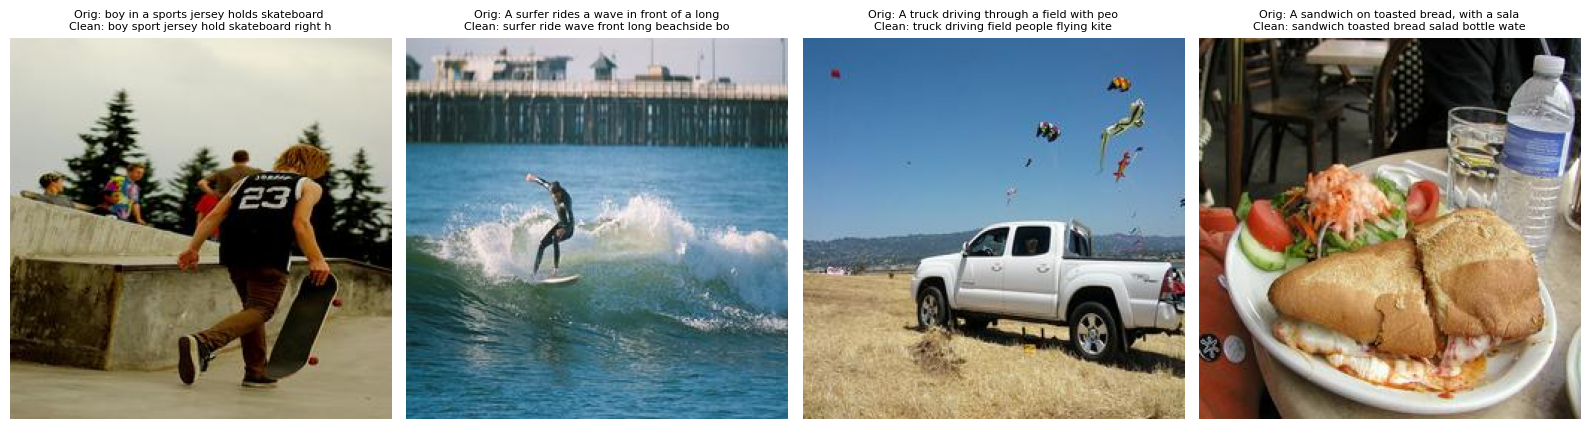

In [ ]:
import matplotlib.pyplot as plt

# Sample 4 images
samples = df.sample(4, random_state=42).reset_index()

plt.figure(figsize=(16, 8))
for i in range(4):
    img = Image.open(samples.loc[i, "resized_image"])
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Orig: {samples.loc[i, 'caption'][:40]}\nClean: {samples.loc[i, 'cleaned_caption'][:40]}", fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
df

,image,caption,resized_image,cleaned_caption
0,/content/coco_mini/images/000000390902.jpg,A man standing on a tennis court holding a rac...,/content/coco_mini/resized_images/000000390902...,man standing tennis court holding racquet
1,/content/coco_mini/images/000000390902.jpg,a man holding a tennis racquet on a tennis court,/content/coco_mini/resized_images/000000390902...,man holding tennis racquet tennis court
2,/content/coco_mini/images/000000390902.jpg,A man intensely looking while holding a tennis...,/content/coco_mini/resized_images/000000390902...,man intensely looking holding tennis racquet
3,/content/coco_mini/images/000000390902.jpg,A man on a tennis court holding his racket and...,/content/coco_mini/resized_images/000000390902...,man tennis court holding racket waiting
4,/content/coco_mini/images/000000390902.jpg,a young man in a red shirt is playing tennis,/content/coco_mini/resized_images/000000390902...,young man red shirt playing tennis
...,...,...,...,...
997,/content/coco_mini/images/000000232538.jpg,A yellow and blue train is next to an overhang.,/content/coco_mini/resized_images/000000232538...,yellow blue train next overhang
998,/content/coco_mini/images/000000232538.jpg,A train sits on the track at a deserted statio...,/content/coco_mini/resized_images/000000232538...,train sits track deserted station overlooked t...
999,/content/coco_mini/images/000000232538.jpg,A colorful train stopped at a train station.,/content/coco_mini/resized_images/000000232538...,colorful train stopped train station
1000,/content/coco_mini/images/000000232538.jpg,A passenger train stopped near a train station.,/content/coco_mini/resized_images/000000232538...,passenger train stopped near train station


In [ ]:
# Keep only 'resized_image' and 'cleaned_caption'
df = df[["resized_image", "cleaned_caption"]]

# Confirm the result
df.head()

,resized_image,cleaned_caption
0,/content/coco_mini/resized_images/000000390902...,man standing tennis court holding racquet
1,/content/coco_mini/resized_images/000000390902...,man holding tennis racquet tennis court
2,/content/coco_mini/resized_images/000000390902...,man intensely looking holding tennis racquet
3,/content/coco_mini/resized_images/000000390902...,man tennis court holding racket waiting
4,/content/coco_mini/resized_images/000000390902...,young man red shirt playing tennis


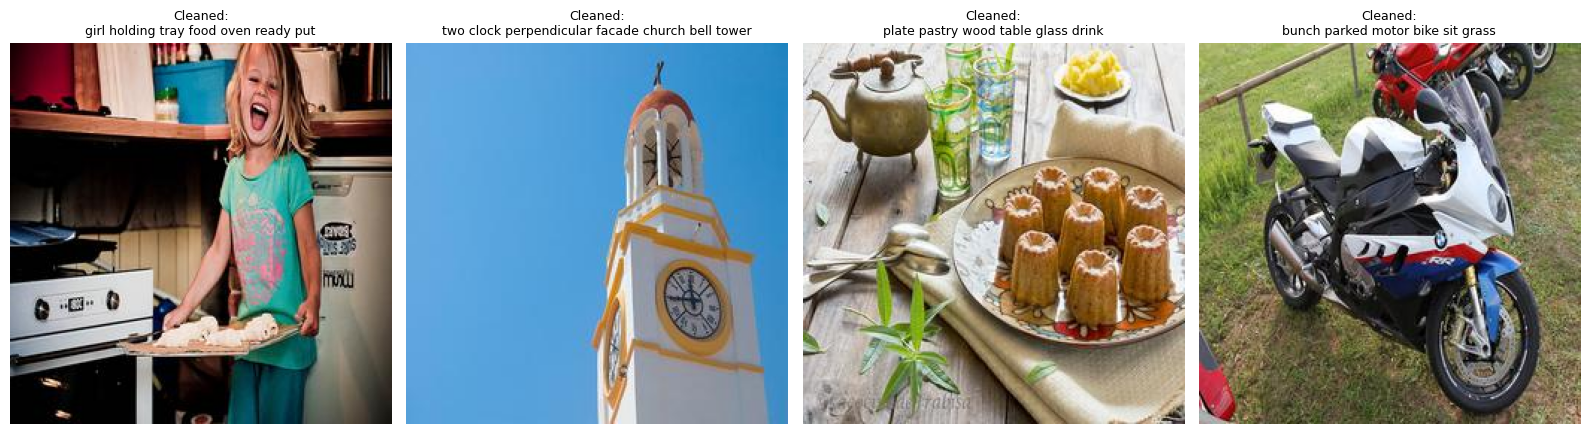

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Sample 4 rows from the cleaned DataFrame
samples = df.sample(4, random_state=123).reset_index(drop=True)

# Plot the images with their cleaned captions
plt.figure(figsize=(16, 8))
for i in range(4):
    try:
        img = Image.open(samples.loc[i, "resized_image"])
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Cleaned:\n{samples.loc[i, 'cleaned_caption']}", fontsize=9)
        plt.axis("off")
    except Exception as e:
        print(f"Error opening image {samples.loc[i, 'resized_image']}: {e}")

plt.tight_layout()
plt.show()

In [ ]:
import os

# Replace full paths with just the filenames
df['resized_image'] = df['resized_image'].apply(os.path.basename)

# Optional: Save to CSV or TXT
df.to_csv('captions_with_filenames.csv', index=False)

<ipython-input-23-90e915ad54af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resized_image'] = df['resized_image'].apply(os.path.basename)


In [ ]:
import os
from PIL import Image

# Create output folder
os.makedirs('resized_images', exist_ok=True)

# Loop over the DataFrame rows
for _, row in df.iterrows():
    image_path_in_df = row['resized_image'] # This is the path where the resized image is currently stored
    # Extract the filename from the resized_image path
    filename = os.path.basename(image_path_in_df)

    # Define the new path where you want to save the image in the 'resized_images' folder
    new_image_path = os.path.join('resized_images', filename)

    try:
        # Open the image from the path stored in the DataFrame
        img_to_save = Image.open(image_path_in_df)

        # Save the image using PIL to the new path
        img_to_save.save(new_image_path)

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path_in_df}")
    except Exception as e:
        print(f"Error processing {image_path_in_df}: {e}")

In [ ]:

# Compress and save the 'resized_images' folder
!zip -r /content/resized_images.zip /content/resized_images

  adding: content/resized_images/ (stored 0%)
  adding: content/resized_images/000000121673.jpg (deflated 1%)
  adding: content/resized_images/000000500477.jpg (deflated 1%)
  adding: content/resized_images/000000092660.jpg (deflated 1%)
  adding: content/resized_images/000000355817.jpg (deflated 1%)
  adding: content/resized_images/000000289343.jpg (deflated 1%)
  adding: content/resized_images/000000561679.jpg (deflated 1%)
  adding: content/resized_images/000000124636.jpg (deflated 1%)
  adding: content/resized_images/000000201646.jpg (deflated 2%)
  adding: content/resized_images/000000191614.jpg (deflated 1%)
  adding: content/resized_images/000000377882.jpg (deflated 1%)
  adding: content/resized_images/000000288762.jpg (deflated 1%)
  adding: content/resized_images/000000159399.jpg (deflated 1%)
  adding: content/resized_images/000000197022.jpg (deflated 1%)
  adding: content/resized_images/000000213605.jpg (deflated 1%)
  adding: content/resized_images/000000179112.jpg (deflate